<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [60]:
%pip install statstests

In [61]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [62]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features_60min.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_parquet('/content/datasets/transactions_features_60min.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [64]:
df.head()

,date_window,transactions,frauds,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_technology_telecommunications,category_professional_business_services,category_health_medical,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,2010-01-01 00:00:00,24,0,54.625000,14.436706,62517.708333,735.416667,62.858652,4.291667,1.458980,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,21,0,55.285714,13.961171,58580.571429,737.000000,57.964644,4.333333,1.622755,...,0.05,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,25,0,51.680000,17.199128,73585.080000,726.120000,53.216006,3.400000,1.384437,...,0.00,0.04,0.04,0.04,0.04,0.00,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,20,0,51.300000,15.791737,48200.000000,716.600000,61.796270,3.700000,1.260743,...,0.15,0.00,0.05,0.00,0.05,0.00,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,16,0,54.687500,13.636807,54884.312500,678.375000,74.337855,4.125000,1.707825,...,0.00,0.00,0.06,0.00,0.00,0.06,0.0,0.0,0.0,0.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86150 entries, 0 to 86149
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              86150 non-null  datetime64[us]
 1   transactions                             86150 non-null  uint32        
 2   frauds                                   86150 non-null  int32         
 3   mean_current_age                         86150 non-null  float64       
 4   std_current_age                          86140 non-null  float64       
 5   mean_total_debt                          86150 non-null  float64       
 6   mean_credit_score                        86150 non-null  float64       
 7   std_credit_score                         86140 non-null  float64       
 8   mean_num_credit_cards                    86150 non-null  float64       
 9   std_num_credit_cards                   

In [66]:
df.describe()

,date_window,transactions,frauds,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,...,category_technology_telecommunications,category_professional_business_services,category_health_medical,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
count,86150,86150.000000,86150.000000,86150.000000,86140.000000,86150.000000,86150.000000,86140.000000,86150.000000,86140.000000,...,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000,86150.000000
mean,2014-12-01 15:19:52.157864,98.342240,0.149066,53.872361,15.528723,57871.428731,714.361608,64.433640,3.851517,1.567645,...,0.042237,0.008886,0.068054,0.004368,0.008644,0.004945,0.000536,0.028486,0.010282,0.008552
min,2010-01-01 00:00:00,1.000000,0.000000,26.000000,4.041452,686.000000,651.000000,14.977390,1.000000,0.534522,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 05:15:00,31.000000,0.000000,52.647059,14.703299,53723.412319,708.829200,60.458336,3.728916,1.480251,...,0.010000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
50%,2014-12-01 14:30:00,90.000000,0.000000,53.949275,15.626140,57780.436029,714.397659,64.999329,3.846154,1.564966,...,0.030000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.010000
75%,2017-05-17 13:45:00,155.000000,0.000000,55.165284,16.446761,61817.039474,719.664797,69.204912,3.964706,1.648713,...,0.050000,0.010000,0.090000,0.000000,0.010000,0.010000,0.000000,0.040000,0.010000,0.010000
max,2019-10-31 23:00:00,236.000000,9.000000,82.000000,26.279817,124771.000000,788.000000,108.086925,7.000000,3.000000,...,0.500000,0.270000,0.450000,1.000000,0.250000,0.200000,0.670000,1.000000,1.000000,0.170000
std,NaN,58.835156,0.580392,2.247060,1.540722,6865.318362,9.408593,8.130745,0.231128,0.162707,...,0.045020,0.017053,0.037599,0.012796,0.013809,0.010712,0.003793,0.026016,0.019918,0.011017


In [67]:
pd.concat([df['frauds'].value_counts(normalize=True), df['frauds'].value_counts()], axis=1)

,proportion,count
frauds,,
0,0.913117,78665
1,0.050145,4320
2,0.021648,1865
3,0.009008,776
4,0.003587,309
5,0.001381,119
6,0.000708,61
7,0.000209,18
8,0.000139,12


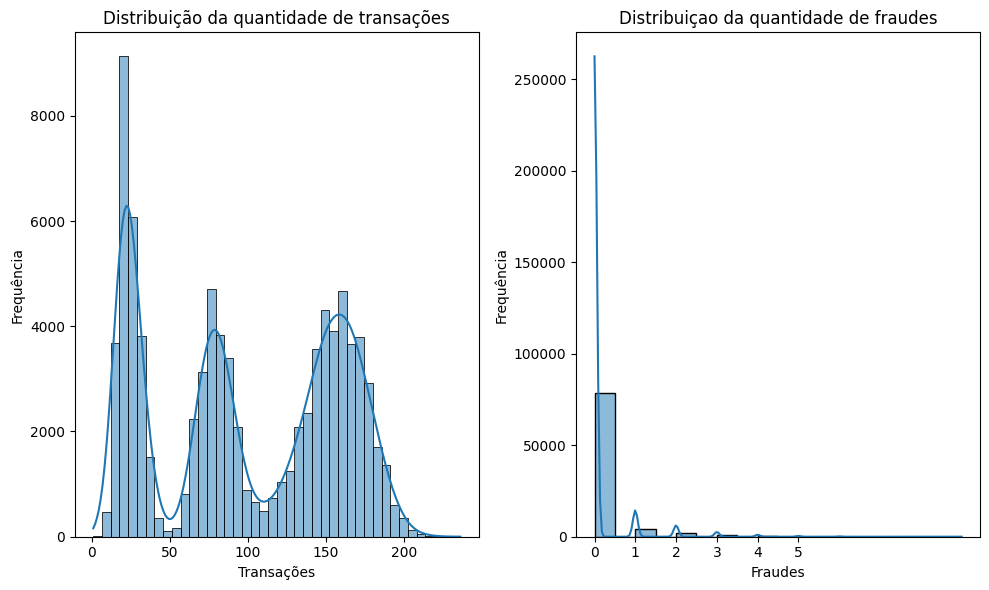

In [68]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title('Distribuição da quantidade de transações')
sns.histplot(df['transactions'], kde=True)
plt.xlabel('Transações')
plt.ylabel('Frequência')

plt.subplot(122)
plt.title('Distribuiçao da quantidade de fraudes')
sns.histplot(df['frauds'], kde=True)
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, 6, 1))

plt.tight_layout()
plt.show()

## Implementação de Modelos

In [69]:
y = df['frauds']
X = df.drop(columns=['date_window'])

### Função de Comparação

In [70]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [71]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [72]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [73]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.

---

### Utilização

O modelo de regressão de Poisson é indicado para modelar variáveis discretas de contagem com:

- Distribuição assimétrica à direita;
- Muitos zeros e poucos valores altos;
- Relação entre média e variância próximas (equidispersão).



In [74]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.149066,0.336855


Há indícios de superdispersão.

In [75]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ transactions + mean_current_age + std_current_age + mean_total_debt + mean_credit_score + std_credit_score + mean_num_credit_cards + std_num_credit_cards + skew_num_credit_cards + kurtosis_num_credit_cards + mean_credit_limit + gender_male + card_brand_amex + card_brand_discover + card_type_debit_prepaid + has_chip_no + category_food_beverage + category_transportation_logistics + category_retail_specialty + category_retail_general_department + category_financial_insurance + category_arts_entertainment_recreation + category_government_utilities + category_technology_telecommunications + category_professional_business_services + category_health_medical + category_travel_hospitality + category_retail_clothing_accessories + category_sports_recreation + category_construction_contractors + category_retail_home_garden + category_manufacturing_industrial + category_personal_services'

In [76]:
modelo_poison_simple = smf.glm(formula='frauds ~ transactions', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86150
Model:                            GLM   Df Residuals:                    86148
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36889.
Date:                Tue, 15 Jul 2025   Deviance:                       56159.
Time:                        22:52:11   Pearson chi2:                 1.52e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1174
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.2964      0.034   -127.400      0.000      -4.362      -4.230
transactions     0.0189      0.000     86.386      0.000       0.018       0.019
================================================================================
"""

Observações do modelo simples

* Intercepto e variavel `transactions` são estatisticamente significantes
* O Log-Likelihood é alto
* Pseudo R-Squ. (CS) indique que apenas a variavel `transaction` explica menos que ~ 11% da variância na contagem de fraudes.



In [77]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson()).fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86106
Model Family:                 Poisson   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36458.
Date:                Tue, 15 Jul 2025   Deviance:                       55298.
Time:                        22:52:12   Pearson chi2:                 1.54e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1261
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   5.7240      1.369      4.181      0.000       3.041       8.407
transactions                                0.0203      0.000     65.920      0.000       0.020       0.021
mean_current_age                            0.0135      0.007      1.850      0.064      -0.001       0.028
std_current_age                            -0.0359      0.010     -3.693      0.000      -0.055      -0.017
mean_total_debt                         -4.688e-06   2.09e-06     -2.240      0.025   -8.79e-06   -5.87e-07
mean_credit_score                          -0.0121      0.002     -7.943      0.000      -0.015      -0.009
std_credit_score                           -0.0073      0.002     -4.004      0.000      -0.011      -0.004
mean_num_credit_cards                       0.3732      0.072      5.188      0.000       0.232       0.514
std_num_credit_cards                       -0.2781      0.104     -2.681      0.007      -0.481      -0.075
skew_num_credit_cards                       0.3445      0.070      4.956      0.000       0.208       0.481
kurtosis_num_credit_cards                  -0.0107      0.035     -0.308      0.758      -0.079       0.057
mean_credit_limit                       -8.172e-07   9.01e-06     -0.091      0.928   -1.85e-05    1.68e-05
gender_male                                -1.3822      0.183     -7.568      0.000      -1.740      -1.024
card_brand_amex                            -2.1223      0.390     -5.435      0.000      -2.888      -1.357
card_brand_discover                         2.8537      0.576      4.958      0.000       1.725       3.982
card_type_debit_prepaid                     0.9688      0.377      2.569      0.010       0.230       1.708
has_chip_no                                 0.1198      0.311      0.385      0.700      -0.491       0.730
category_food_beverage                     -1.4401      0.718     -2.006      0.045      -2.848      -0.033
category_transportation_logistics          -2.2303      0.732     -3.047      0.002      -3.665      -0.796
category_retail_specialty                  -4.3919      0.830     -5.294      0.000      -6.018      -2.766
category_retail_general_department          1.9022      0.753      2.527      0.012       0.427       3.377
category_financial_insurance               -0.0541      0.824     -0.066      0.948      -1.669       1.560
category_arts_entertainment_recreation     -3.6334      0.895     -4.058      0.000      -5.388      -1.879
category_government_utilities              -4.4288      0.861     -5.143      0.000      -6.117      -2.741
category_technology_telecommunications     -1.1248      0.810     -1.389      0.165      -2.711       0.462
category_professional_business_services    -4.8752      1.2

In [78]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.009      
Dependent Variable:     ystar            AIC:                         610796.1326
Date:                   2025-07-15 22:52 BIC:                         610805.4963
No. Observations:       86140            Log-Likelihood:              -3.0540e+05
Df Model:               1                F-statistic:                 767.3      
Df Residuals:           86139            Prob (F-statistic):          3.88e-168  
R-squared (uncentered): 0.009            Scale:                       70.305     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.7758         0.1363       27.6995       0.0000       3.5086    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

In [79]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('gender_male') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_food_beverage') + Q('category_transportation_logistics') + Q('category_retail_specialty') + Q('category_retail_general_department') + Q('category_financial_insurance') + Q('category_arts_entertainment_recreation') + Q('category_government_utilities') + Q('category_technology_telecommunications') + Q('category_professional_business_services') + Q('category_health_medical') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_sports_recreation') + Q('category_construction_contractors') + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86115
Model Family:                 Poisson   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36462.
Date:                Tue, 15 Jul 2025   Deviance:                       55306.
Time:                        22:52:21   Pearson chi2:                 1.54e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1260
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        6.5722      1.132      5.804      0.000       4.353       8.792
Q('transactions')                                0.0203      0.000     68.197      0.000       0.020       0.021
Q('std_current_age')                            -0.0315      0.009     -3.357      0.001      -0.050      -0.013
Q('mean_total_debt')                         -5.938e-06   1.84e-06     -3.224      0.001   -9.55e-06   -2.33e-06
Q('mean_credit_score')                          -0.0124      0.002     -8.191      0.000      -0.015      -0.009
Q('std_credit_score')                           -0.0070      0.002     -3.872      0.000      -0.011      -0.003
Q('mean_num_credit_cards')                       0.4136      0.065      6.330      0.000       0.286       0.542
Q('std_num_credit_cards')                       -0.2621      0.094     -2.795      0.005      -0.446      -0.078
Q('skew_num_credit_cards')                       0.3227      0.049      6.645      0.000       0.228       0.418
Q('gender_male')                                -1.3843      0.183     -7.582      0.000      -1.742      -1.026
Q('card_brand_amex')                            -2.1026      0.386     -5.441      0.000      -2.860      -1.345
Q('card_brand_discover')                         2.8357      0.574      4.941      0.000       1.711       3.961
Q('card_type_debit_prepaid')                     0.9901      0.348      2.843      0.004       0.308       1.673
Q('category_food_beverage')                     -1.5336      0.282     -5.445      0.000      -2.086      -0.982
Q('category_transportation_logistics')          -2.3140      0.324     -7.141      0.000      -2.949      -1.679
Q('category_retail_specialty')                  -4.4221      0.536     -8.248      0.000      -5.473      -3.371
Q('category_retail_general_department')          1.8339      0.379      4.844      0.000       1.092       2.576
Q('category_arts_entertainment_recreation')     -3.7915      0.595     -6.373      0.000      -4.958      -2.625
Q('category_government_utilities')              -4.4994      0.590     -7.631      0.000      -5.655      -3.344
Q('category_technology_telecommunications')     -1.1457      0.517     -2.217      0.027      -2.158      -0.133
Q('category_professional_business_services')    -4.9170      1.091     -4.507      0.000      -7.055      -2.779
Q('category_health_medical')                    -3.4504      0.434     -7.947      0.000      -4.301      -2.599
Q('category_travel_hospitality')                 3.4649      1.204      2.877      0.004       1.105       5.825
Q('category_retail_clothing_accessories')        3.2904      1.002      3.284      0.001       1.327       5.254
Q('category_personal_services') 

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [80]:
overdisp(modelo_poisson_stepswise, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.009      
Dependent Variable:     ystar            AIC:                         611479.3013
Date:                   2025-07-15 22:52 BIC:                         611488.6650
No. Observations:       86140            Log-Likelihood:              -3.0574e+05
Df Model:               1                F-statistic:                 761.6      
Df Residuals:           86139            Prob (F-statistic):          6.51e-167  
R-squared (uncentered): 0.009            Scale:                       70.865     
---------------------------------------------------------------------------------------
             Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda        3.7770         0.1369       27.5968       0.0000       3.5087    

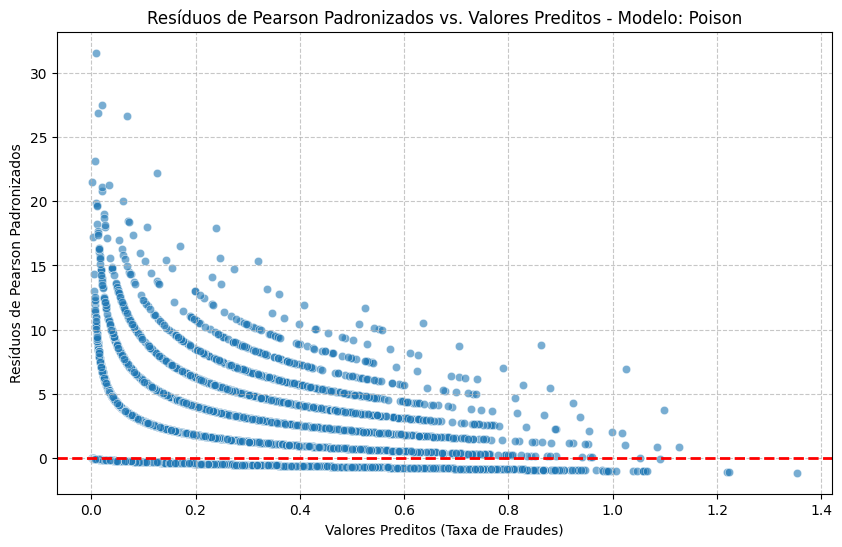

In [81]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [82]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-4.2964***,5.7240***,6.5722***
,(0.0337),(1.3689),(1.1323)
transactions,0.0189***,0.0203***,
,(0.0002),(0.0003),
mean_current_age,,0.0135*,
,,(0.0073),
std_current_age,,-0.0359***,
,,(0.0097),
mean_total_debt,,-0.0000**,
,,(0.0000),


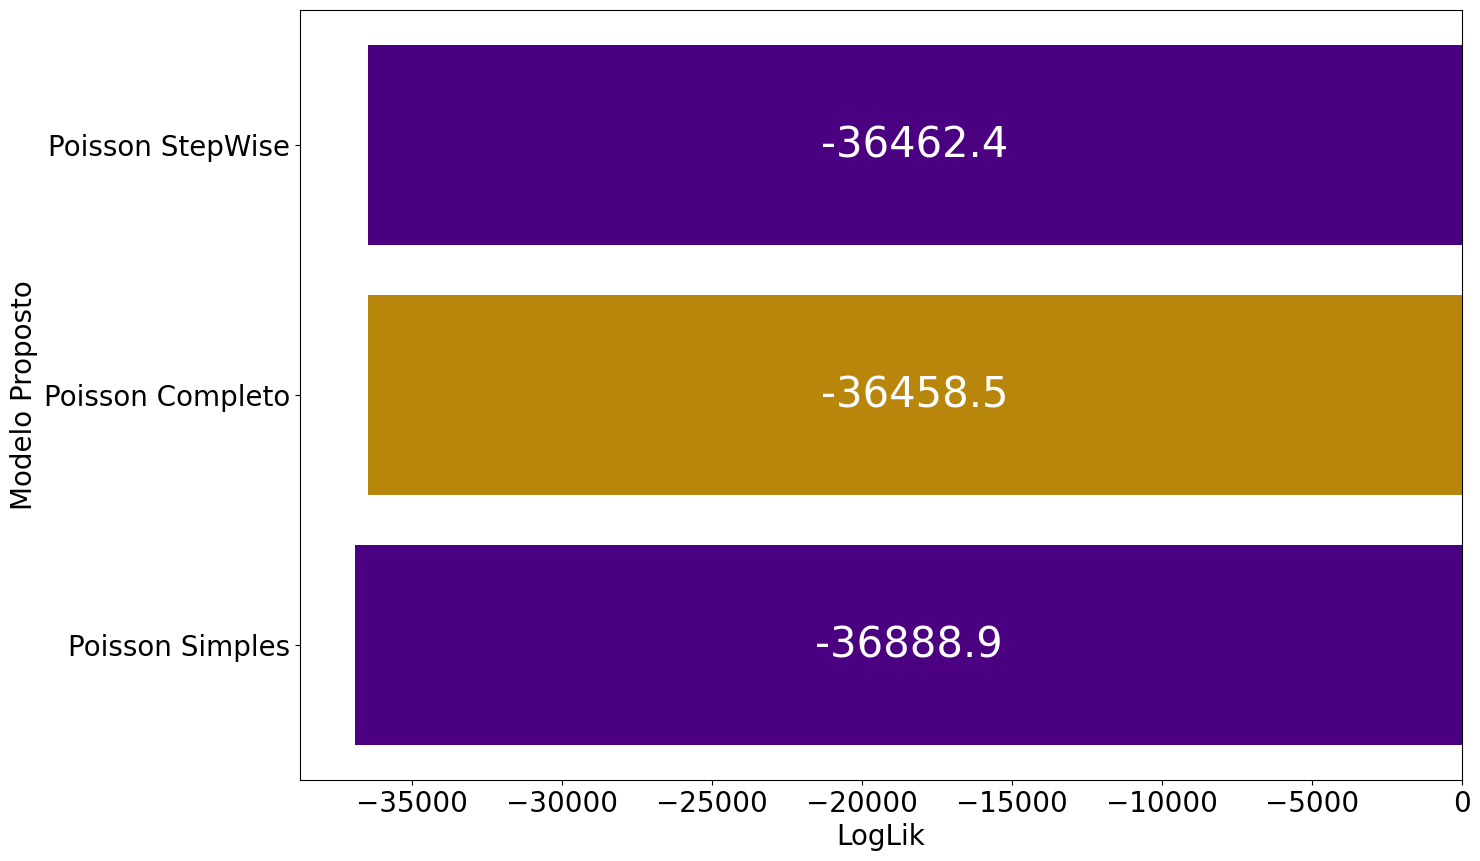

In [83]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida, conforme discutido no capítulo "Modelos de Regressão para Dados de Contagem" do manual.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.

---

### Quando Utilizar

- Dados de contagem com variância > média.
- Cenários onde o modelo de Poisson apresenta sobredispersão detectada via testes estatísticos.
- Alternativa robusta ao Poisson, sem necessidade de recorrer a modelos com inflação de zeros ou estruturas mais complexas.

---

**Nota:** A orientação para uso e interpretação desses modelos, incluindo verificação de sobredispersão, seleção de variáveis e diagnóstico de modelo, segue os princípios estabelecidos no capítulo 14 do manual.


In [84]:
modelo_binomialneg_simples = smf.glm(formula='frauds ~ transactions', data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86150
Model:                            GLM   Df Residuals:                    86148
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33500.
Date:                Tue, 15 Jul 2025   Deviance:                       41653.
Time:                        22:52:22   Pearson chi2:                 1.31e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1033
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.3064      0.035   -122.128      0.000      -4.375      -4.237
transactions     0.0189      0.000     81.111      0.000       0.018       0.019
================================================================================
"""

In [85]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86106
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33168.
Date:                Tue, 15 Jul 2025   Deviance:                       40989.
Time:                        22:52:23   Pearson chi2:                 1.33e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1102
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   6.7220      1.512      4.447      0.000       3.759       9.685
transactions                                0.0201      0.000     59.346      0.000       0.019       0.021
mean_current_age                            0.0156      0.008      1.949      0.051   -9.17e-05       0.031
std_current_age                            -0.0344      0.011     -3.224      0.001      -0.055      -0.013
mean_total_debt                         -4.309e-06    2.3e-06     -1.875      0.061   -8.81e-06    1.95e-07
mean_credit_score                          -0.0133      0.002     -7.951      0.000      -0.017      -0.010
std_credit_score                           -0.0074      0.002     -3.716      0.000      -0.011      -0.004
mean_num_credit_cards                       0.3735      0.079      4.741      0.000       0.219       0.528
std_num_credit_cards                       -0.2301      0.113     -2.031      0.042      -0.452      -0.008
skew_num_credit_cards                       0.3846      0.076      5.051      0.000       0.235       0.534
kurtosis_num_credit_cards                  -0.0042      0.038     -0.111      0.912      -0.079       0.071
mean_credit_limit                       -3.099e-06   9.92e-06     -0.313      0.755   -2.25e-05    1.63e-05
gender_male                                -1.3880      0.199     -6.975      0.000      -1.778      -0.998
card_brand_amex                            -2.0278      0.427     -4.746      0.000      -2.865      -1.190
card_brand_discover                         2.6716      0.629      4.249      0.000       1.439       3.904
card_type_debit_prepaid                     0.9476      0.413      2.292      0.022       0.137       1.758
has_chip_no                                 0.1371      0.341      0.402      0.688      -0.532       0.806
category_food_beverage                     -1.7977      0.819     -2.195      0.028      -3.403      -0.192
category_transportation_logistics          -2.5102      0.834     -3.009      0.003      -4.145      -0.875
category_retail_specialty                  -4.5179      0.934     -4.839      0.000      -6.348      -2.688
category_retail_general_department          1.3388      0.855      1.566      0.117      -0.336       3.014
category_financial_insurance               -0.4526      0.931     -0.486      0.627      -2.278       1.373
category_arts_entertainment_recreation     -3.9637      1.000     -3.963      0.000      -5.924      -2.004
category_government_utilities              -4.7665      0.963     -4.949      0.000      -6.654      -2.879
category_technology_telecommunications     -1.8398      0.907     -2.027      0.043      -3.618      -0.061
category_professional_business_services    -5.3656      1.3

In [86]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('mean_current_age') + Q('std_current_age') + Q('mean_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('mean_num_credit_cards') + Q('std_num_credit_cards') + Q('skew_num_credit_cards') + Q('kurtosis_num_credit_cards') + Q('mean_credit_limit') + Q('gender_male') + Q('card_brand_amex') + Q('card_brand_discover') + Q('card_type_debit_prepaid') + Q('has_chip_no') + Q('category_food_beverage') + Q('category_transportation_logistics') + Q('category_retail_specialty') + Q('category_retail_general_department') + Q('category_financial_insurance') + Q('category_arts_entertainment_recreation') + Q('category_government_utilities') + Q('category_technology_telecommunications') + Q('category_professional_business_services') + Q('category_health_medical') + Q('category_travel_hospitality') + Q('category_retail_clothing_accessories') + Q('category_sports_recreation') + Q('category_construction_contractors') + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                86140
Model:                            GLM   Df Residuals:                    86115
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33172.
Date:                Tue, 15 Jul 2025   Deviance:                       40996.
Time:                        22:52:33   Pearson chi2:                 1.33e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1101
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        7.2576      1.239      5.859      0.000       4.830       9.685
Q('transactions')                                0.0201      0.000     61.555      0.000       0.019       0.021
Q('std_current_age')                            -0.0296      0.010     -2.872      0.004      -0.050      -0.009
Q('mean_total_debt')                         -5.896e-06   2.03e-06     -2.900      0.004   -9.88e-06   -1.91e-06
Q('mean_credit_score')                          -0.0136      0.002     -8.183      0.000      -0.017      -0.010
Q('std_credit_score')                           -0.0070      0.002     -3.546      0.000      -0.011      -0.003
Q('mean_num_credit_cards')                       0.4241      0.072      5.923      0.000       0.284       0.564
Q('std_num_credit_cards')                       -0.2209      0.103     -2.153      0.031      -0.422      -0.020
Q('skew_num_credit_cards')                       0.3709      0.053      6.956      0.000       0.266       0.475
Q('gender_male')                                -1.3871      0.199     -6.977      0.000      -1.777      -0.997
Q('card_brand_amex')                            -2.0019      0.423     -4.734      0.000      -2.831      -1.173
Q('card_brand_discover')                         2.6482      0.627      4.225      0.000       1.420       3.877
Q('card_type_debit_prepaid')                     1.0006      0.381      2.624      0.009       0.253       1.748
Q('category_food_beverage')                     -1.5288      0.311     -4.918      0.000      -2.138      -0.920
Q('category_transportation_logistics')          -2.2240      0.358     -6.214      0.000      -2.925      -1.523
Q('category_retail_specialty')                  -4.1845      0.586     -7.145      0.000      -5.332      -3.037
Q('category_retail_general_department')          1.6357      0.416      3.935      0.000       0.821       2.450
Q('category_arts_entertainment_recreation')     -3.7663      0.637     -5.916      0.000      -5.014      -2.519
Q('category_government_utilities')              -4.4833      0.639     -7.016      0.000      -5.736      -3.231
Q('category_technology_telecommunications')     -1.5266      0.559     -2.730      0.006      -2.623      -0.430
Q('category_professional_business_services')    -5.0815      1.178     -4.312      0.000      -7.391      -2.772
Q('category_health_medical')                    -3.1878      0.477     -6.690      0.000      -4.122      -2.254
Q('category_travel_hospitality')                 2.7763      1.345      2.063      0.039       0.139       5.413
Q('category_retail_clothing_accessories')        3.3910      1.093      3.103      0.002       1.249       5.533
Q('category_personal_services') 

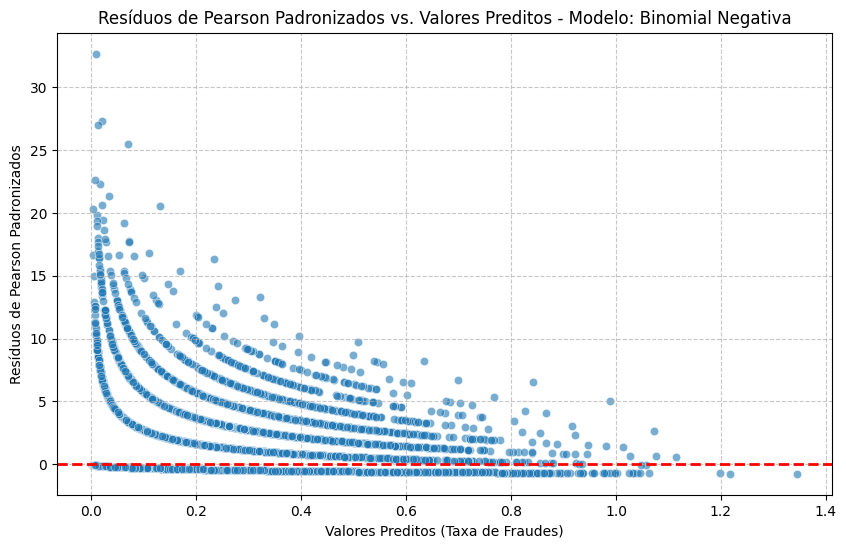

In [87]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [88]:
lrtest([modelo_poisson_stepswise, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): 6581.41
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


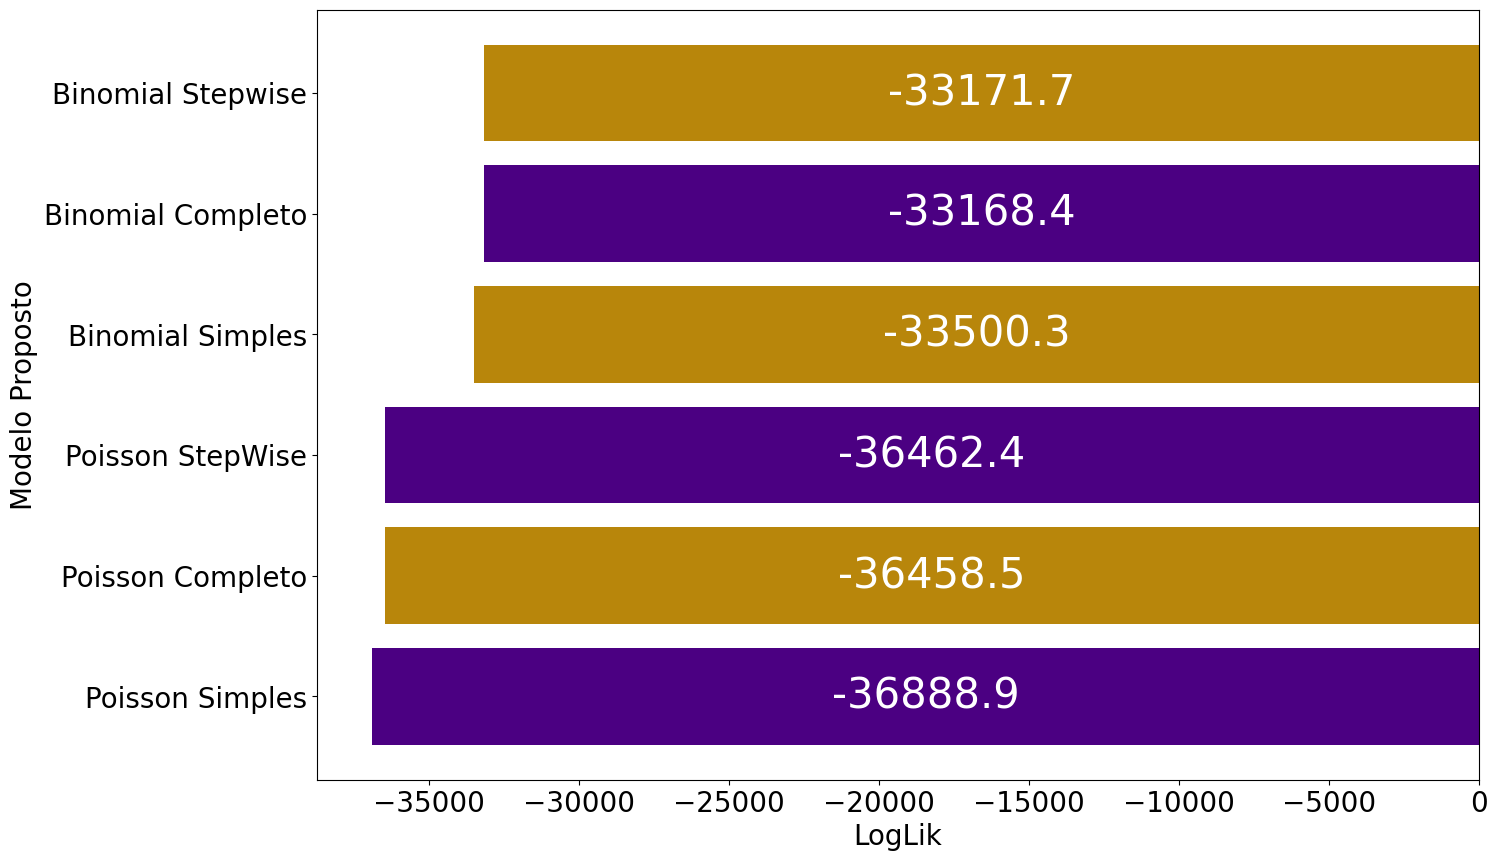

In [89]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.


In [90]:
X1 = X['transactions'].copy()
X1 = sm.add_constant(X1)

In [91]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_simples.summary()

         Current function value: 0.370333
         Iterations: 35
         Function evaluations: 65
         Gradient evaluations: 65


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86150
Model:             ZeroInflatedPoisson   Df Residuals:                    86148
Method:                            MLE   Df Model:                            1
Date:                 Tue, 15 Jul 2025   Pseudo R-squ.:                 0.07191
Time:                         22:52:38   Log-Likelihood:                -31904.
converged:                       False   LL-Null:                       -34376.
Covariance Type:             nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            0.6188      0.049     12.550      0.000       0.522       0.715
inflate_transactions     0.0035      0.000     10.684      0.000       0.003       0.004
const                   -2.8743      0.032    -88.561      0.000      -2.938      -2.811
transactions             0.0192      0.000     89.863      0.000       0.019       0.020
========================================================================================
"""

In [92]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 0.428194
         Iterations 7
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -35.785
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [93]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

,transactions,mean_current_age,std_current_age,mean_total_debt,mean_credit_score,std_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,...,category_technology_telecommunications,category_professional_business_services,category_health_medical,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,3.218876,4.018633,2.736748,11.043221,6.601796,4.156672,1.666133,0.899747,-0.096525,-0.154196,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,3.091042,4.030441,2.705458,10.978175,6.603944,4.076938,1.673976,0.964225,-0.133789,NaN,...,0.048790,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,3.258097,3.964236,2.901374,11.206211,6.589092,3.992976,1.481605,0.868963,0.405479,-0.800821,...,0.000000,0.039221,0.039221,0.039221,0.039221,0.000000,0.0,0.0,0.0,0.0
3,3.044522,3.956996,2.820887,10.783135,6.575912,4.139896,1.547563,0.815694,0.460762,-0.711337,...,0.139762,0.000000,0.048790,0.000000,0.048790,0.000000,0.0,0.0,0.0,0.0
4,2.833213,4.019756,2.683539,10.913001,6.521173,4.321983,1.634131,0.996146,0.194839,0.163340,...,0.000000,0.000000,0.058269,0.000000,0.000000,0.058269,0.0,0.0,0.0,0.0


In [94]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [95]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped)

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.columns).drop(columns='frauds')
X_scaler.head()

,transactions,mean_current_age,mean_total_debt,mean_credit_score,mean_num_credit_cards,mean_credit_limit,gender_male,card_brand_amex,card_brand_discover,card_type_debit_prepaid,...,category_technology_telecommunications,category_professional_business_services,category_health_medical,category_travel_hospitality,category_retail_clothing_accessories,category_sports_recreation,category_construction_contractors,category_retail_home_garden,category_manufacturing_industrial,category_personal_services
0,-1.263576,0.334946,0.676779,2.237867,1.904367,-0.038344,1.731901,-0.698093,-1.129226,2.588144,...,-0.938176,-0.521105,-1.810000,-0.341395,-0.625952,-0.461615,-0.141397,-1.094941,-0.516232,-0.776249
1,-1.314566,0.628982,0.103294,2.406154,2.084644,3.868514,-2.460491,1.008422,-1.129226,-0.521863,...,0.172436,-0.521105,-1.810000,-0.341395,-0.625952,-0.461615,-0.141397,-1.094941,-0.516232,-0.776249
2,-1.246579,-0.975663,2.288859,1.249758,-1.953549,-0.197489,1.477817,0.439584,-1.129226,1.292308,...,-0.938176,1.824503,-0.746137,2.784627,2.270791,-0.461615,-0.141397,-1.094941,-0.516232,-0.776249
3,-1.331563,-1.144774,-1.408745,0.237911,-0.655559,-0.438664,-0.427816,1.008422,-1.129226,2.069809,...,2.393659,-0.521105,-0.480171,-0.341395,2.994977,-0.461615,-0.141397,-1.094941,-0.516232,-0.776249
4,-1.399550,0.362760,-0.435105,-3.824888,1.183261,1.021325,-1.317111,-0.129255,-1.129226,-1.817700,...,-0.938176,-0.521105,-0.214205,-0.341395,-0.625952,5.139796,-0.141397,-1.094941,-0.516232,-0.776249


In [96]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [97]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zip_complete.summary()

         Current function value: 0.363248
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86150
Model:             ZeroInflatedPoisson   Df Residuals:                    86121
Method:                            MLE   Df Model:                           28
Date:                 Tue, 15 Jul 2025   Pseudo R-squ.:                 0.08967
Time:                         22:52:54   Log-Likelihood:                -31294.
converged:                       False   LL-Null:                       -34376.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.5112      0.021     71.678      0.000       1.470       1.553
inflate_transactions                               -0.3240      0.026    -12.275      0.000      -0.376      -0.272
inflate_mean_current_age                           -0.0324      0.024     -1.373      0.170      -0.079       0.014
inflate_mean_total_debt                             0.0010      0.021      0.046      0.963      -0.040       0.042
inflate_mean_credit_score                          -0.0698      0.020     -3.461      0.001      -0.109      -0.030
inflate_mean_num_credit_cards                      -0.1047      0.024     -4.398      0.000      -0.151      -0.058
inflate_mean_credit_limit                          -0.0561      0.022     -2.600      0.009      -0.098      -0.014
inflate_gender_male                                 0.1868      0.021      8.730      0.000       0.145       0.229
inflate_card_brand_amex                            -0.0120      0.020     -0.587      0.557      -0.052       0.028
inflate_card_brand_discover                        -0.0434      0.020     -2.199      0.028      -0.082      -0.005
inflate_card_type_debit_prepaid                    -0.0613      0.022     -2.821      0.005      -0.104      -0.019
inflate_has_chip_no                                 0.0473      0.019      2.427      0.015       0.009       0.085
inflate_category_food_beverage                      0.1897      0.107      1.778      0.075      -0.019       0.399
inflate_category_transportation_logistics           0.0732      0.086      0.856      0.392      -0.094       0.241
inflate_category_retail_specialty                   0.3664      0.035     10.338      0.000       0.297       0.436
inflate_category_retail_general_department          0.0169      0.062      0.273      0.785      -0.104       0.138
inflate_category_financial_insurance                0.0668      0.037      1.803      0.071      -0.006       0.139
inflate_category_arts_entertainment_recreation      0.3598      0.040      8.955      0.000       0.281       0.439
inflate_category_government_utilities              -0.0379      0.045     -0.848      0.396      -0.125       0.050
inflate_category_technology_telecommunications     -0.2030      0.058     -3.526      0.000      -0.316      -0.090
inflate_category_professional_business_services    -0.0404      0.032     -1.283      0.200      -0.102       0.021
inflate_category_health_medical                     0.1697      0.046      3.687      0.000       0.079       0.260
inflate_category_travel_hospitality                -0.0198      0.027     -0.749      0.454      -0.072       0.032
inflate_category_retail_clothing_accessories       -0.0470      0.025     -1.906      0.057      -0.095       0.001
inflate_category_sports_recreation                  0.0326      0.023      1.400      0.161      -0.

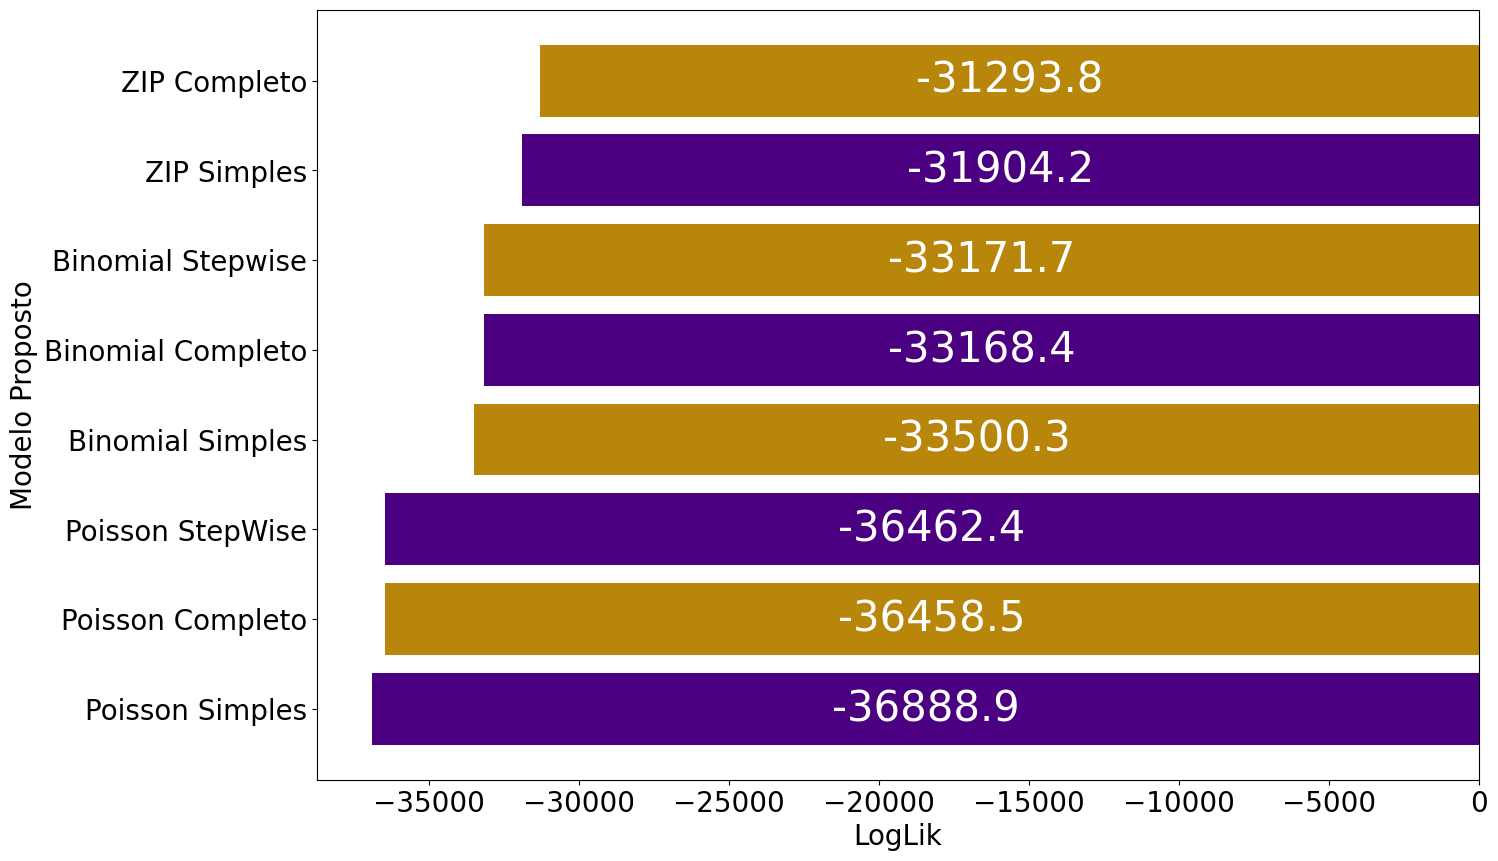

In [98]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [99]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))

In [100]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_stepwise = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zip_stepwise.summary()

         Current function value: 0.364216
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86150
Model:             ZeroInflatedPoisson   Df Residuals:                    86134
Method:                            MLE   Df Model:                           15
Date:                 Tue, 15 Jul 2025   Pseudo R-squ.:                 0.08724
Time:                         22:53:02   Log-Likelihood:                -31377.
converged:                       False   LL-Null:                       -34376.
Covariance Type:             nonrobust   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      1.4861      0.022     68.823      0.000       1.444       1.528
inflate_transactions                              -0.2906      0.023    -12.440      0.000      -0.336      -0.245
inflate_mean_credit_score                         -0.1402      0.020     -6.909      0.000      -0.180      -0.100
inflate_mean_num_credit_cards                     -0.0610      0.022     -2.815      0.005      -0.104      -0.019
inflate_mean_credit_limit                         -0.0249      0.020     -1.220      0.222      -0.065       0.015
inflate_gender_male                                0.2034      0.022      9.434      0.000       0.161       0.246
inflate_card_brand_discover                       -0.0406      0.020     -2.001      0.045      -0.080      -0.001
inflate_card_type_debit_prepaid                   -0.0529      0.021     -2.461      0.014      -0.095      -0.011
inflate_has_chip_no                                0.0286      0.020      1.436      0.151      -0.010       0.068
inflate_category_retail_specialty                  0.3996      0.021     19.329      0.000       0.359       0.440
inflate_category_arts_entertainment_recreation     0.3265      0.021     15.309      0.000       0.285       0.368
inflate_category_technology_telecommunications    -0.3084      0.033     -9.309      0.000      -0.373      -0.243
inflate_category_health_medical                    0.0776      0.020      3.945      0.000       0.039       0.116
inflate_category_retail_home_garden               -0.0107      0.021     -0.514      0.607      -0.052       0.030
inflate_category_manufacturing_industrial         -0.0017      0.022     -0.078      0.938      -0.045       0.042
const                                             -0.8322      0.017    -47.755      0.000      -0.866      -0.798
transactions                                       0.9255      0.019     49.963      0.000       0.889       0.962
mean_total_debt                                   -0.0726      0.015     -4.891      0.000      -0.102      -0.044
mean_credit_score                                 -0.2127      0.015    -13.781      0.000      -0.243      -0.182
mean_credit_limit                                 -0.0251      0.016     -1.575      0.115      -0.056       0.006
gender_male                                        0.0232      0.017      1.385      0.166      -0.010       0.056
card_brand_amex                                   -0.0886      0.016     -5.475      0.000      -0.120      -0.057
has_chip_no                                        0.0166      0.015      1.081      0.280      -0.014       0.047
category_retail_specialty                          0.1716      0.016     10.518      0.000       0.140       0.204
category_arts_entertainment_recreation             0.1760      0.018      9.649      0.000       0.140       0.212
category_gov

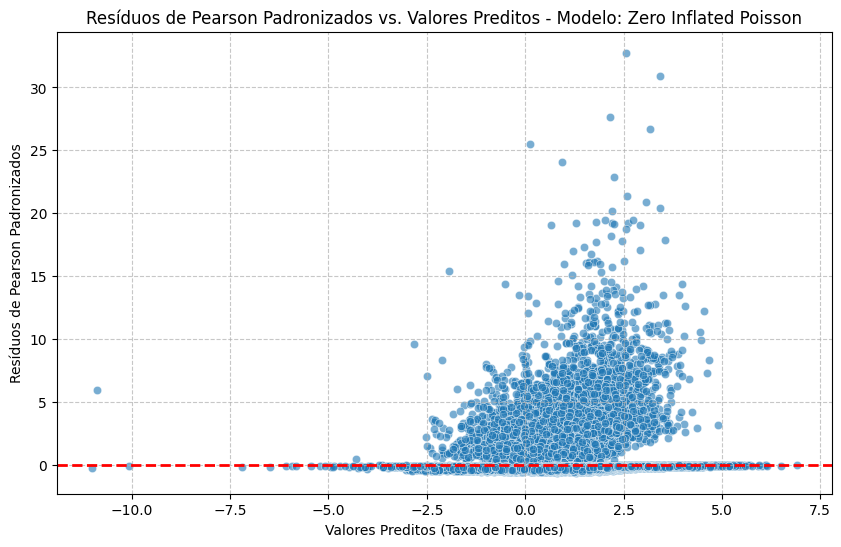

In [101]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [102]:
X_scaler.columns.to_list()

['transactions',
 'mean_current_age',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'gender_male',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_food_beverage',
 'category_transportation_logistics',
 'category_retail_specialty',
 'category_retail_general_department',
 'category_financial_insurance',
 'category_arts_entertainment_recreation',
 'category_government_utilities',
 'category_technology_telecommunications',
 'category_professional_business_services',
 'category_health_medical',
 'category_travel_hospitality',
 'category_retail_clothing_accessories',
 'category_sports_recreation',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

mean_current_age , 'mean_credit_limit', 'card_type_debit_prepaid', 'has_chip_no', 'category_financial_insurance', 'category_government_utilities', 'category_sports_recreation','category_construction_contractors', 'category_retail_home_garden', 'category_manufacturing_industrial', 'category_personal_services'


**'category_food_beverage',** -> category_arts_entertainment_recreation'

In [103]:
X1 = X_scaler[
    [
        'transactions',
        'mean_credit_score',
        'gender_male',
        'card_brand_amex',
        'card_brand_discover',
        'category_transportation_logistics',
        'category_travel_hospitality',

    ]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[
    [
     'transactions',
     'mean_total_debt',
     'mean_num_credit_cards',
     'gender_male',
     'category_retail_specialty',
     'category_retail_general_department',
     'category_arts_entertainment_recreation',
     'category_professional_business_services',
     'category_health_medical',
     'category_retail_clothing_accessories',
    ]].copy()
X2 = sm.add_constant(X2)

modelo_zip_stepwise_manual = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zip_stepwise_manual.summary()

         Current function value: 0.362302
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                86150
Model:             ZeroInflatedPoisson   Df Residuals:                    86142
Method:                            MLE   Df Model:                            7
Date:                 Tue, 15 Jul 2025   Pseudo R-squ.:                 0.09204
Time:                         22:53:08   Log-Likelihood:                -31212.
converged:                       False   LL-Null:                       -34376.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       2.0047      0.019    107.072      0.000       1.968       2.041
inflate_transactions                               -0.6797      0.019    -35.182      0.000      -0.718      -0.642
inflate_mean_total_debt                             0.0624      0.017      3.568      0.000       0.028       0.097
inflate_mean_num_credit_cards                      -0.0675      0.020     -3.428      0.001      -0.106      -0.029
inflate_gender_male                                 0.1837      0.020      9.179      0.000       0.144       0.223
inflate_category_retail_specialty                   0.1702      0.020      8.453      0.000       0.131       0.210
inflate_category_retail_general_department         -0.1448      0.018     -7.974      0.000      -0.180      -0.109
inflate_category_arts_entertainment_recreation      0.0888      0.020      4.530      0.000       0.050       0.127
inflate_category_professional_business_services     0.0820      0.025      3.272      0.001       0.033       0.131
inflate_category_health_medical                     0.0611      0.019      3.302      0.001       0.025       0.097
inflate_category_retail_clothing_accessories       -0.0585      0.019     -3.070      0.002      -0.096      -0.021
const                                              -0.3562      0.017    -20.696      0.000      -0.390      -0.323
transactions                                        0.6341      0.017     37.158      0.000       0.601       0.668
mean_credit_score                                  -0.1062      0.015     -6.909      0.000      -0.136      -0.076
gender_male                                         0.0561      0.017      3.317      0.001       0.023       0.089
card_brand_amex                                    -0.0719      0.016     -4.380      0.000      -0.104      -0.040
card_brand_discover                                 0.0452      0.016      2.843      0.004       0.014       0.076
category_transportation_logistics                  -0.0778      0.016     -4.845      0.000      -0.109      -0.046
category_travel_hospitality                         0.0442      0.016      2.689      0.007       0.012       0.076
===================================================================================================================
"""

LLH: -31212

Psuedo R2: 0.09204

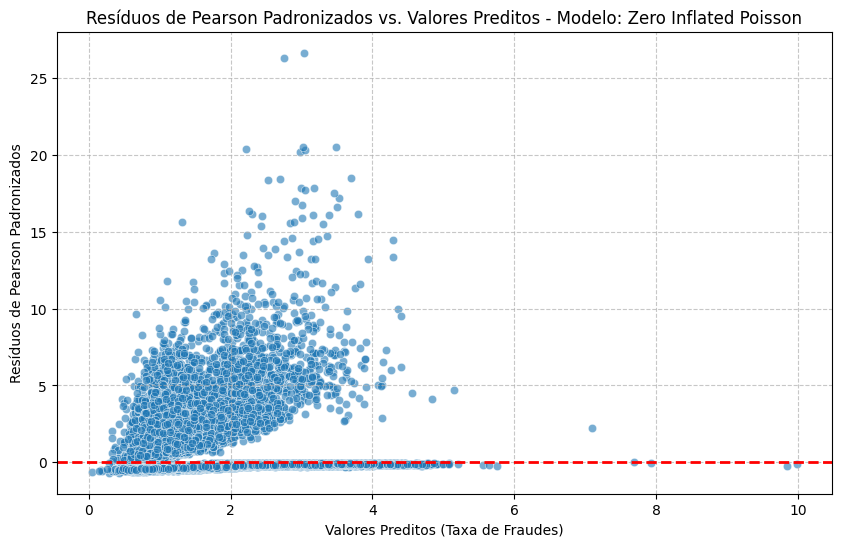

In [104]:
overdisp_plot(modelo_zip_stepwise_manual, 'Zero Inflated Poisson')

In [105]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise_manual])

Likelihood Ratio Test:
-2.(LL0-LLm): 329.85
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


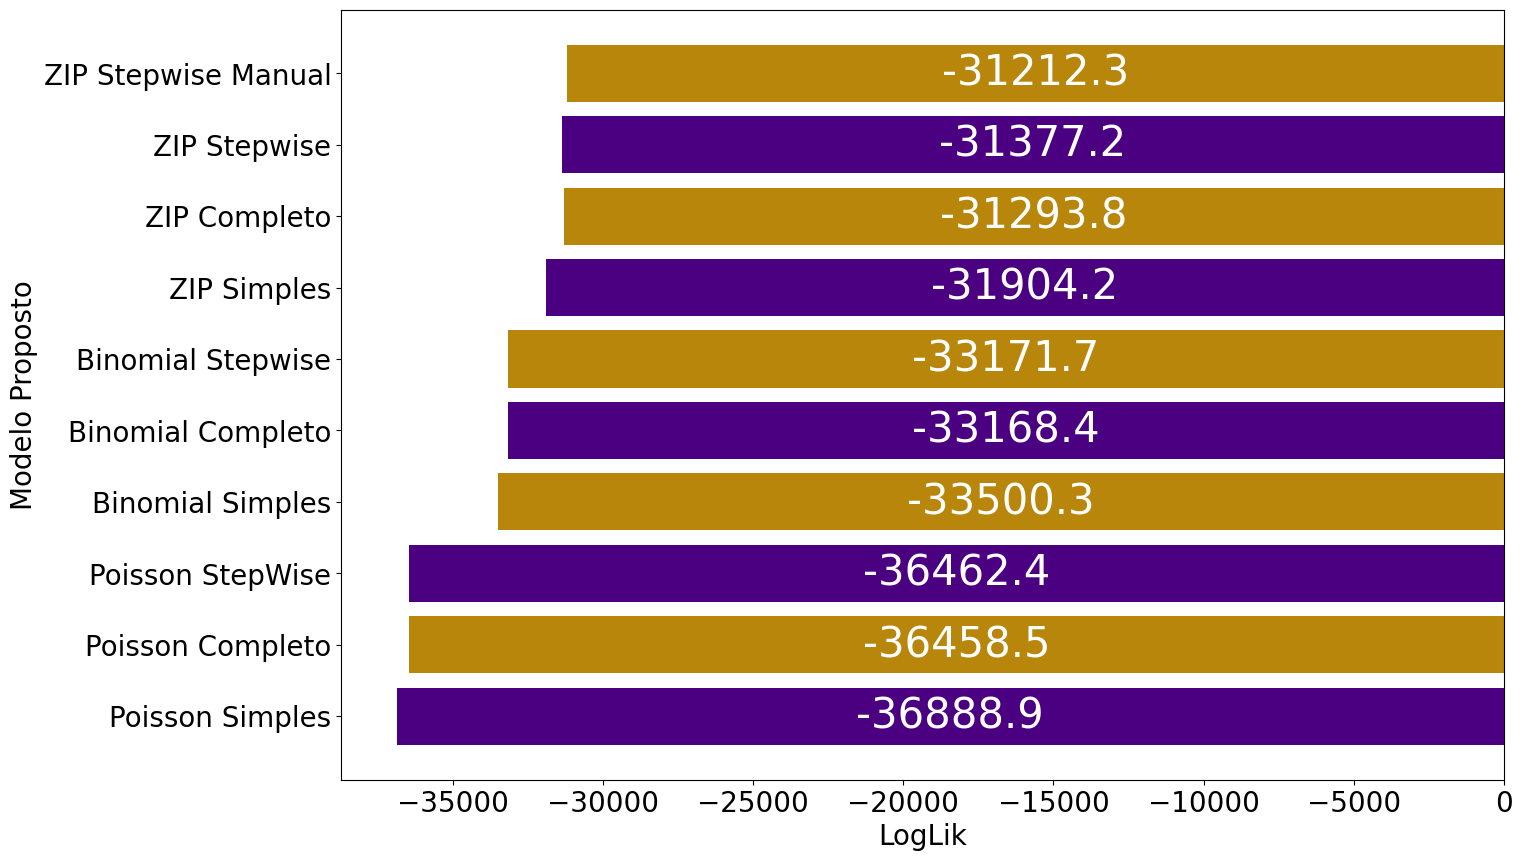

In [106]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZIP Stepwise Manual'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zip_stepwise_manual.llf
      ]
})

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


In [107]:
X1 = X_scaler['transactions']
X1 = sm.add_constant(X1)

In [108]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_simples.summary()

         Current function value: 0.364682
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86150
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86148
Method:                                      MLE   Df Model:                            1
Date:                           Tue, 15 Jul 2025   Pseudo R-squ.:                 0.08030
Time:                                   22:53:22   Log-Likelihood:                -31417.
converged:                                 False   LL-Null:                       -34160.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const           -0.7870      0.188     -4.194      0.000      -1.155      -0.419
inflate_transactions    -1.5349      0.100    -15.290      0.000      -1.732      -1.338
const                   -1.9048      0.058    -33.118      0.000      -2.018      -1.792
transactions             0.7003      0.038     18.609      0.000       0.627       0.774
alpha                    5.0248      0.224     22.428      0.000       4.586       5.464
========================================================================================
"""

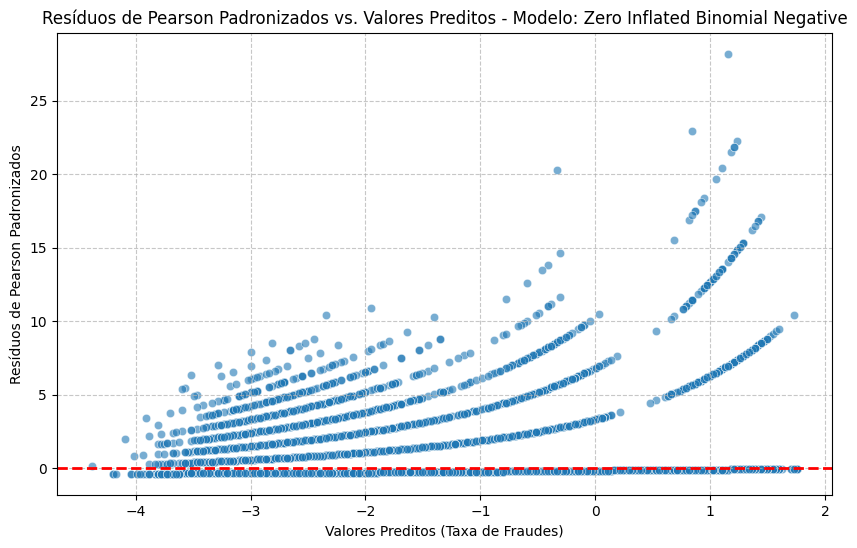

In [109]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [110]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 0.366052
         Iterations: 16
         Function evaluations: 27
         Gradient evaluations: 27
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -7.724
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [111]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [112]:
modelo_zinb_complete = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='logit').fit()
modelo_zinb_complete.summary()

         Current function value: 0.366293
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86150
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86121
Method:                                      MLE   Df Model:                           28
Date:                           Tue, 15 Jul 2025   Pseudo R-squ.:                 0.07624
Time:                                   22:56:48   Log-Likelihood:                -31556.
converged:                                 False   LL-Null:                       -34160.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                      -5.0703        nan        nan        nan         nan         nan
inflate_transactions                               -3.4090        nan        nan        nan         nan         nan
inflate_mean_current_age                           -0.3798        nan        nan        nan         nan         nan
inflate_mean_total_debt                            -0.2050        nan        nan        nan         nan         nan
inflate_mean_credit_score                           0.2204        nan        nan        nan         nan         nan
inflate_mean_num_credit_cards                       0.0155        nan        nan        nan         nan         nan
inflate_mean_credit_limit                           0.0647        nan        nan        nan         nan         nan
inflate_gender_male                                 0.2661        nan        nan        nan         nan         nan
inflate_card_brand_amex                             0.1299        nan        nan        nan         nan         nan
inflate_card_brand_discover                         0.1895        nan        nan        nan         nan         nan
inflate_card_type_debit_prepaid                    -0.2438        nan        nan        nan         nan         nan
inflate_has_chip_no                                -0.0945        nan        nan        nan         nan         nan
inflate_category_food_beverage                     -0.0676        nan        nan        nan         nan         nan
inflate_category_transportation_logistics          -0.4664        nan        nan        nan         nan         nan
inflate_category_retail_specialty                  -0.7499        nan        nan        nan         nan         nan
inflate_category_retail_general_department          0.1330        nan        nan        nan         nan         nan
inflate_category_financial_insurance                0.3504        nan        nan        nan         nan         nan
inflate_category_arts_entertainment_recreation      1.1626        nan        nan        nan         nan         nan
inflate_category_government_utilities              -0.0311        nan        nan        nan         nan         nan
inflate_category_technology_telecommunications      0.7995        nan        nan        nan         nan         nan
inflate_category_professional_business_services     0.0205        nan        nan        nan         nan         nan
inflate_category_health_medical                    -0.5146        nan        nan        nan         nan         nan
inflate_category_travel_hospitality                -0.1416        nan        nan        nan         nan         nan
inflate_category_retail_clothing_accessories       -0.2763        nan        nan        nan         nan         nan
inflate_ca

In [113]:
X_scaler.columns.to_list()

['transactions',
 'mean_current_age',
 'mean_total_debt',
 'mean_credit_score',
 'mean_num_credit_cards',
 'mean_credit_limit',
 'gender_male',
 'card_brand_amex',
 'card_brand_discover',
 'card_type_debit_prepaid',
 'has_chip_no',
 'category_food_beverage',
 'category_transportation_logistics',
 'category_retail_specialty',
 'category_retail_general_department',
 'category_financial_insurance',
 'category_arts_entertainment_recreation',
 'category_government_utilities',
 'category_technology_telecommunications',
 'category_professional_business_services',
 'category_health_medical',
 'category_travel_hospitality',
 'category_retail_clothing_accessories',
 'category_sports_recreation',
 'category_construction_contractors',
 'category_retail_home_garden',
 'category_manufacturing_industrial',
 'category_personal_services']

In [114]:
X1 = X_scaler[
    [
        'transactions',
        # 'mean_current_age',
        'mean_credit_score'
    ]].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[
    [
        'transactions',
    ]].copy()
X2 = sm.add_constant(X2)

modelo_zinb_stepwise_manual = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2, inflation='logit').fit()
modelo_zinb_stepwise_manual.summary()

         Current function value: 0.364662
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                86150
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    86147
Method:                                      MLE   Df Model:                            2
Date:                           Tue, 15 Jul 2025   Pseudo R-squ.:                 0.08035
Time:                                   22:57:03   Log-Likelihood:                -31416.
converged:                                 False   LL-Null:                       -34160.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const           -0.8967      0.252     -3.553      0.000      -1.391      -0.402
inflate_transactions    -1.3926      0.109    -12.760      0.000      -1.607      -1.179
const                   -1.9657      0.074    -26.650      0.000      -2.110      -1.821
transactions             0.7666      0.046     16.695      0.000       0.677       0.857
mean_credit_score       -0.1055      0.019     -5.656      0.000      -0.142      -0.069
alpha                    5.0312      0.273     18.459      0.000       4.497       5.565
========================================================================================
"""

LLH:  -31416

Pseudo R: 0.08035

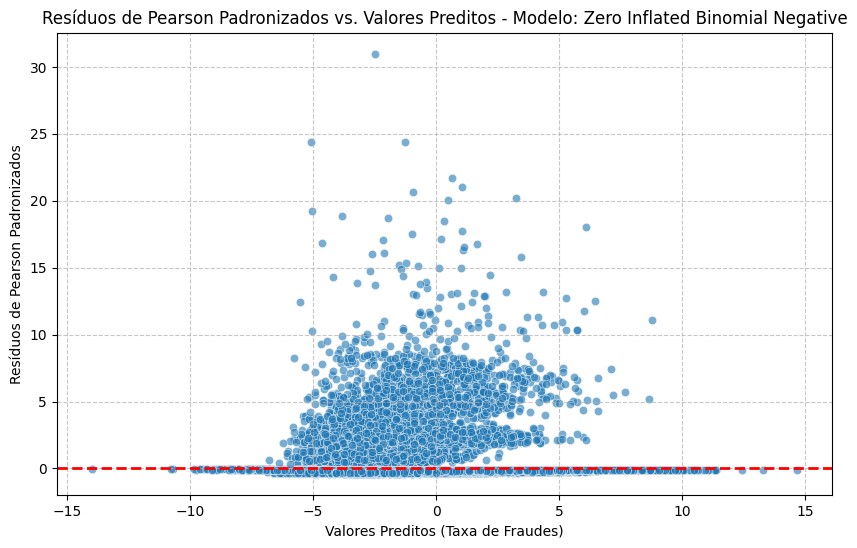

In [115]:
overdisp_plot(modelo_zinb_stepwise_manual, 'Zero Inflated Binomial Negative')

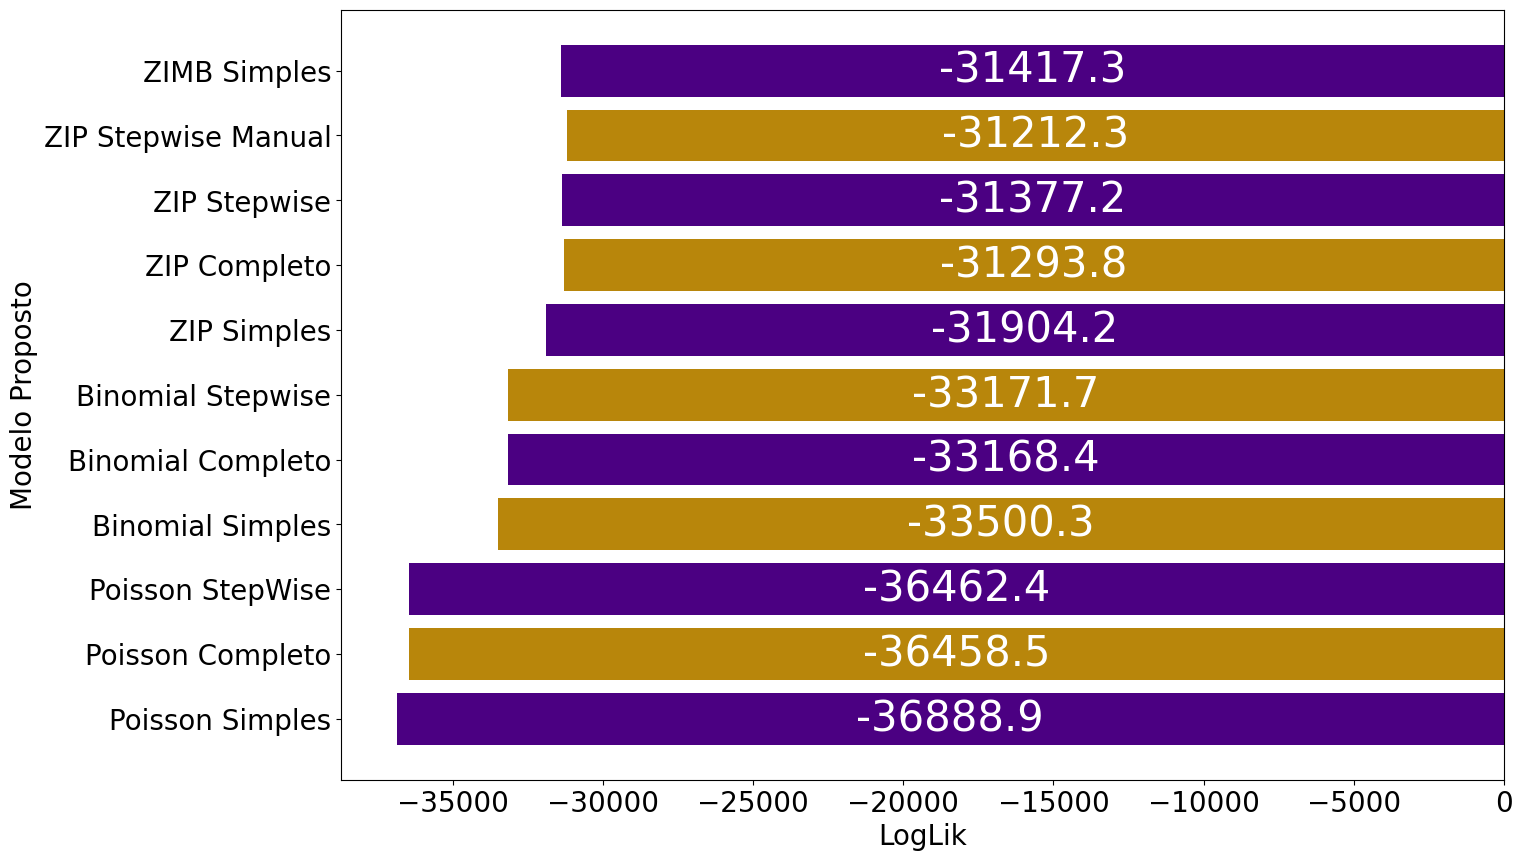

In [116]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZIP Stepwise Manual',
        'ZIMB Simples'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zip_stepwise_manual.llf,
        modelo_zinb_simples.llf
      ]
})